In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/excavator/train")
count_images("datasets/excavator/valid")

Total images: 642
Total images: 54


In [ ]:
# Unzip it
!unzip -q /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/excavator.zip -d /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/justnow

In [ ]:
# This is just for converting det bb annotations to keypoints (not used here)

import json

def bbox_center(bbox):
    x, y, w, h = bbox
    return [x + w / 2, y + h / 2]

def convert_order_based(det_json_path, out_json_path):
    with open(det_json_path) as f:
        data = json.load(f)

    annotations = data['annotations']
    annotations.sort(key=lambda x: x['id'])  # ensure order by annotation ID

    new_annotations = []
    next_ann_id = 1

    i = 0
    while i < len(annotations):
        ann = annotations[i]
        if ann['category_id'] == 1:
            excavator = ann
            parts = {k: None for k in range(2, 9)}  # p0 to p6

            i += 1
            while i < len(annotations) and annotations[i]['category_id'] != 1:
                part_cat = annotations[i]['category_id']
                if part_cat in parts and parts[part_cat] is None:
                    parts[part_cat] = annotations[i]
                i += 1

            keypoints = []
            num_keypoints = 0
            for k in range(2, 9):
                if parts[k]:
                    cx, cy = bbox_center(parts[k]['bbox'])
                    keypoints += [cx, cy, 2]
                    num_keypoints += 1
                else:
                    keypoints += [0, 0, 0]

            new_annotations.append({
                'id': next_ann_id,
                'image_id': excavator['image_id'],
                'category_id': 1,
                'bbox': excavator['bbox'],
                'area': excavator.get('area', excavator['bbox'][2] * excavator['bbox'][3]),
                'iscrowd': 0,
                'keypoints': keypoints,
                'num_keypoints': num_keypoints
            })
            next_ann_id += 1
        else:
            i += 1

    output = {
        'info': data.get('info', {}),
        'licenses': data.get('licenses', []),
        'images': data['images'],
        'annotations': new_annotations,
        'categories': [{
            'id': 1,
            'name': 'Excavator',
            'supercategory': 'none',
            'keypoints': ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6'],
            'skeleton': [
                [1, 2], [2, 3], [3, 4],
                [4, 5], [5, 6], [6, 7],
                [7, 6], [6, 5], [5, 7]  # triangle for bucket
            ]
        }]
    }

    with open(out_json_path, 'w') as f:
        json.dump(output, f, indent=2)

# 🔧 Usage
convert_order_based(
    "datasets/excavator/valid/_annotations.coco.json",
    "datasets/excavator/valid/_annotations.keypoints.json"
)

In [ ]:
import json

in_path = "datasets/excavator/valid/_annotations.coco.json"
out_path = "datasets/excavator/valid/_annotations_fixed.coco.json"

with open(in_path, "r") as f:
    coco = json.load(f)

# Automatically find the category with annotations
used_cat_ids = set(ann["category_id"] for ann in coco["annotations"])

# Filter only the used categories
coco["categories"] = [cat for cat in coco["categories"] if cat["id"] in used_cat_ids]

# Add keypoints/skeleton if missing
for cat in coco["categories"]:
    if "keypoints" not in cat:
        cat["keypoints"] = ["bucket","hinge1","hinge2","driver_seat","rear","b_hinge"]
    if "skeleton" not in cat:
        cat["skeleton"] = [[1,6],[2,3],[3,4],[4,5],[6,2]]

# (Optional) Force all annotations to correct category ID if you're merging 0/1 confusion
correct_id = coco["categories"][0]["id"]
for ann in coco["annotations"]:
    ann["category_id"] = correct_id

# Save the fixed file
with open(out_path, "w") as f:
    json.dump(coco, f)

print(f"✅ Cleaned and fixed JSON saved to: {out_path}")

✅ Cleaned and fixed JSON saved to: datasets/excavator/valid/_annotations_fixed.coco.json


In [ ]:
import json

json_path = "datasets/excavator/valid/_annotations_fixed.coco.json"

with open(json_path, "r") as f:
    coco = json.load(f)

for ann in coco["annotations"]:
    if "keypoints" in ann:
        kps = ann["keypoints"]
        # Count how many keypoints have visibility > 0
        num_vis = sum(1 for i in range(2, len(kps), 3) if kps[i] > 0)
        ann["num_keypoints"] = num_vis
    else:
        ann["num_keypoints"] = 0

with open(json_path, "w") as f:
    json.dump(coco, f)

print("✅ Patched: Added num_keypoints to all annotations")

✅ Patched: Added num_keypoints to all annotations


In [3]:
train_json = "datasets/excavator/train/_annotations_fixed.coco.json"
valid_json = "datasets/excavator/valid/_annotations_fixed.coco.json"

In [4]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import os
import math
import random

def visualize_coco_keypoints(json_path, img_dir, num_images=9):
    coco = COCO(json_path)
    img_ids = coco.getImgIds()
    random.shuffle(img_ids)
    num_images = min(num_images, len(img_ids))

    # Find category that has keypoints
    cats = coco.loadCats(coco.getCatIds())
    cat_with_kps = next((cat for cat in cats if 'keypoints' in cat and 'skeleton' in cat), None)

    if not cat_with_kps:
        print("No category with keypoints and skeleton found.")
        return

    keypoint_names = cat_with_kps['keypoints']
    skeleton = cat_with_kps['skeleton']

    cols = 3
    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()

    for idx in range(num_images):
        img_id = img_ids[idx]
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        anns = coco.loadAnns(ann_ids)

        ax = axes[idx]
        ax.imshow(img)

        for ann in anns:
            if 'keypoints' not in ann:
                continue

            kps = ann['keypoints']
            keypoints_xyv = [(kps[i], kps[i+1], kps[i+2]) for i in range(0, len(kps), 3)]

            # Plot skeleton lines
            for pair in skeleton:
                idx1, idx2 = pair[0] - 1, pair[1] - 1  # 1-based to 0-based
                if idx1 < len(keypoints_xyv) and idx2 < len(keypoints_xyv):
                    x1, y1, v1 = keypoints_xyv[idx1]
                    x2, y2, v2 = keypoints_xyv[idx2]
                    if v1 > 0 and v2 > 0:
                        ax.plot([x1, x2], [y1, y2], 'cyan', linewidth=2)

            # Plot keypoints
            for i, (x, y, v) in enumerate(keypoints_xyv):
                if v > 0:
                    ax.plot(x, y, 'ro' if v == 2 else 'go', markersize=5)
                    ax.text(x + 5, y - 5, keypoint_names[i],
                            fontsize=8,
                            color='blue',
                            ha='left', va='bottom')

        ax.set_title(img_info['file_name'], fontsize=10)
        ax.axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


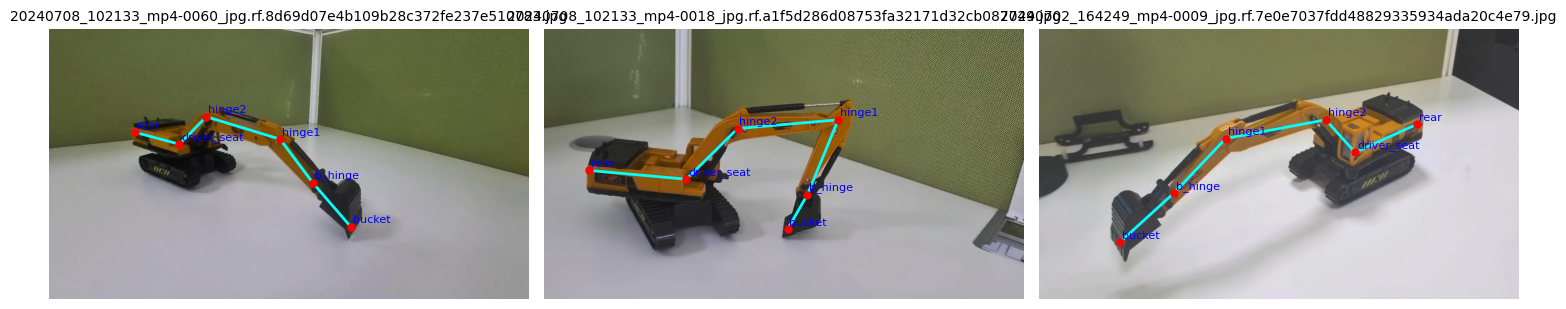

In [ ]:
visualize_coco_keypoints(train_json, "datasets/excavator/train", num_images=3)

In [ ]:
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.cuda.amp.autocast.*")

In [21]:
DATA_DIR = "datasets/excavator"
TRAIN_JSON = f"{DATA_DIR}/train/_annotations_fixed.coco.json"
VAL_JSON = f"{DATA_DIR}/valid/_annotations_fixed.coco.json"
TRAIN_IMG = f"{DATA_DIR}/train"
VAL_IMG = f"{DATA_DIR}/valid"

In [22]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("excavator_train", {}, TRAIN_JSON, TRAIN_IMG)
register_coco_instances("excavator_val", {}, VAL_JSON, VAL_IMG)

In [23]:
from detectron2.data import MetadataCatalog

MetadataCatalog.get("excavator_train").keypoint_names = ["bucket", "hinge1", "hinge2", "driver_seat", "rear", "b_hinge"]
MetadataCatalog.get("excavator_train").keypoint_connection_rules = [
    ('bucket', 'b_hinge', (255, 255, 255)),
    ('hinge1', 'hinge2', (0, 255, 255)),
    ('hinge2', 'driver_seat', (255, 255, 0)),
    ('driver_seat', 'rear', (0, 255, 0)),
    ('b_hinge', 'hinge1', (255, 0, 0)),
]
MetadataCatalog.get("excavator_train").keypoint_flip_map = []

MetadataCatalog.get("excavator_val").keypoint_names = ["bucket", "hinge1", "hinge2", "driver_seat", "rear", "b_hinge"]
MetadataCatalog.get("excavator_val").keypoint_connection_rules = [
    ('bucket', 'b_hinge', (255, 255, 255)),
    ('hinge1', 'hinge2', (0, 255, 255)),
    ('hinge2', 'driver_seat', (255, 255, 0)),
    ('driver_seat', 'rear', (0, 255, 0)),
    ('b_hinge', 'hinge1', (255, 0, 0)),
]
MetadataCatalog.get("excavator_val").keypoint_flip_map = []

[07/25 10:47:01 d2.data.datasets.coco]: Loaded 642 images in COCO format from datasets/excavator/train/_annotations_fixed.coco.json


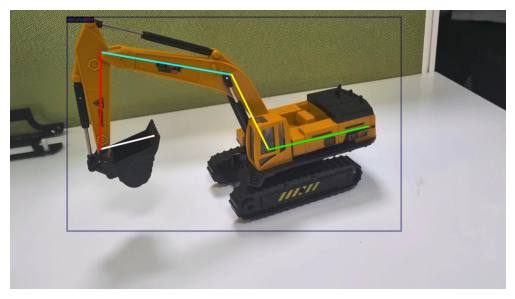

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random, cv2

dataset_dicts = DatasetCatalog.get("excavator_train")
metadata = MetadataCatalog.get("excavator_train")

d = random.choice(dataset_dicts)
img = cv2.imread(d["file_name"])
vis = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
out = vis.draw_dataset_dict(d)
import matplotlib.pyplot as plt
plt.imshow(out.get_image()); plt.axis('off'); plt.show()

In [24]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("excavator_train",)
cfg.DATASETS.TEST = ("excavator_val",)

cfg.TEST.KEYPOINT_OKS_SIGMAS = [
    0.08,  # bucket – small and possibly occluded
    0.06,  # hinge1 – more flexible, more range
    0.05,  # hinge2 – large and rigid, some motion
    0.05,  # driver seat – stable location, rigid
    0.05,  # back of excavator – usually fixed and clearly visible
    0.06,  # bucket joint – joint, may move, moderate localization
]

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8

num_images = 642
epochs = 20
iters_per_epoch = num_images // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs

# Dynamic LR step schedule (50% and 80% of total iters)
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = (
    int(cfg.SOLVER.MAX_ITER * 0.5),
    int(cfg.SOLVER.MAX_ITER * 0.8)
)
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.WEIGHT_DECAY_NORM = 0.0
cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.0

# Evaluate every 5 epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * 4 # 4 epoch
cfg.SOLVER.GAMMA = 0.1
warmup_iters = min(200, int(iters_per_epoch * 2))
cfg.SOLVER.WARMUP_ITERS = warmup_iters

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 3

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6
cfg.MODEL.ROI_HEADS.TRAIN_ON_PRED_BOXES = False
cfg.SOLVER.AMP.ENABLED = True  # Enable automatic mixed precision for speedup

cfg.SOLVER.CHECKPOINT_PERIOD = 200
cfg.OUTPUT_DIR = "/content/.cache/detectron2_keypoints"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [25]:
import os
import torch
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer

class BestModelTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        os.makedirs(output_folder, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, False, output_dir=output_folder)

    def build_hooks(self):
        hooks_list = super().build_hooks()

        # Remove default EvalHook so we can control it
        hooks_list = [h for h in hooks_list if not isinstance(h, hooks.EvalHook)]

        # Add EvalHook
        hooks_list.insert(-1, hooks.EvalHook(
            cfg.TEST.EVAL_PERIOD,
            lambda: inference_on_dataset(
                self.model,
                build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0]),
                self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0])
            )
        ))

        # Custom BestCheckpointer that saves to Drive
        best_model_drive_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth"
        os.makedirs(os.path.dirname(best_model_drive_path), exist_ok=True)
        drive_checkpointer = DetectionCheckpointer(self.model, save_dir=os.path.dirname(best_model_drive_path))

        hooks_list.insert(-1, hooks.BestCheckpointer(
            cfg.TEST.EVAL_PERIOD,
            drive_checkpointer,
            "keypoints/AP",
            "max",
            "keypoint_best"
        ))

        return hooks_list

In [26]:
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data import DatasetMapper, build_detection_train_loader

def custom_mapper(dataset_dict):
    dataset_dict = dataset_dict.copy()
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    # Better augmentations
    aug = [
        T.RandomBrightness(0.8, 1.2),
        T.RandomContrast(0.8, 1.2),
        T.RandomSaturation(0.8, 1.2),
        T.RandomRotation(angle=[-10, 10], expand=False, center=None, sample_style="range"),
        T.ResizeShortestEdge(short_edge_length=(512, 640, 768), max_size=1024, sample_style="choice"),
    ]
    image, transforms = T.apply_transform_gens(aug, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2], keypoint_hflip_indices=None)
        for obj in dataset_dict.pop("annotations")
    ]

    dataset_dict["instances"] = utils.annotations_to_instances(annos, image.shape[:2])
    return dataset_dict

In [27]:
from detectron2.data import build_detection_train_loader

# Fix 1 injection: override data loader with better augmentations
BestModelTrainer.build_train_loader = (
    lambda self, cfg: build_detection_train_loader(cfg, mapper=custom_mapper)
)

In [28]:
torch.cuda.empty_cache()

In [29]:
trainer = BestModelTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/25 19:55:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py:474: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = GradScaler()
model_final_997cc7.pkl: 313MB [00:13, 22.6MB/s]                           
roi_heads.keypoint_head.score_lowres.{bias, weight}


[07/25 19:56:09 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.11/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. P

[07/25 19:56:47 d2.utils.events]:  eta: 0:44:48  iter: 19  total_loss: 9.392  loss_cls: 0.9351  loss_box_reg: 0.3362  loss_keypoint: 8.034  loss_rpn_cls: 0.04428  loss_rpn_loc: 0.00887    time: 1.7169  last_time: 2.1129  data_time: 0.7658  last_data_time: 1.0047   lr: 2.9908e-05  max_mem: 5789M
[07/25 19:57:26 d2.utils.events]:  eta: 0:45:02  iter: 39  total_loss: 8.44  loss_cls: 0.1983  loss_box_reg: 0.2407  loss_keypoint: 8.009  loss_rpn_cls: 0.02008  loss_rpn_loc: 0.006571    time: 1.6714  last_time: 0.9586  data_time: 0.6500  last_data_time: 0.0374   lr: 6.1127e-05  max_mem: 5789M
[07/25 19:58:01 d2.utils.events]:  eta: 0:44:30  iter: 59  total_loss: 8.257  loss_cls: 0.1249  loss_box_reg: 0.2058  loss_keypoint: 7.9  loss_rpn_cls: 0.008877  loss_rpn_loc: 0.006044    time: 1.7071  last_time: 1.7610  data_time: 0.7299  last_data_time: 0.8893   lr: 9.2345e-05  max_mem: 5789M
[07/25 19:58:34 d2.utils.events]:  eta: 0:43:16  iter: 79  total_loss: 7.897  loss_cls: 0.07901  loss_box_reg: 0

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:04:33 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0017 s/iter. Inference: 0.1599 s/iter. Eval: 0.0006 s/iter. Total: 0.1622 s/iter. ETA=0:00:06
[07/25 20:04:38 d2.evaluation.evaluator]: Inference done 39/54. Dataloading: 0.0069 s/iter. Inference: 0.1690 s/iter. Eval: 0.0006 s/iter. Total: 0.1768 s/iter. ETA=0:00:02
[07/25 20:04:41 d2.evaluation.evaluator]: Total inference time: 0:00:08.478920 (0.173039 s / iter per device, on 1 devices)
[07/25 20:04:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:08 (0.164268 s / iter per device, on 1 devices)
[07/25 20:04:41 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:04:41 d2.evaluation.coco_evaluation]: Saving results to /content/.cache/detectron2_keypoints/inference/coco_instances_results.json
[07/25 20:04:41 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index cr

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:12:53 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0012 s/iter. Inference: 0.1544 s/iter. Eval: 0.0004 s/iter. Total: 0.1559 s/iter. ETA=0:00:06
[07/25 20:12:58 d2.evaluation.evaluator]: Inference done 43/54. Dataloading: 0.0044 s/iter. Inference: 0.1548 s/iter. Eval: 0.0005 s/iter. Total: 0.1597 s/iter. ETA=0:00:01
[07/25 20:13:00 d2.evaluation.evaluator]: Total inference time: 0:00:07.935152 (0.161942 s / iter per device, on 1 devices)
[07/25 20:13:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.155252 s / iter per device, on 1 devices)
[07/25 20:13:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:13:00 d2.evaluation.coco_evaluation]: Saving results to /content/.cache/detectron2_keypoints/inference/coco_instances_results.json
[07/25 20:13:00 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index cr

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:21:02 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0036 s/iter. Inference: 0.1552 s/iter. Eval: 0.0004 s/iter. Total: 0.1593 s/iter. ETA=0:00:06
[07/25 20:21:07 d2.evaluation.evaluator]: Inference done 44/54. Dataloading: 0.0021 s/iter. Inference: 0.1528 s/iter. Eval: 0.0004 s/iter. Total: 0.1554 s/iter. ETA=0:00:01
[07/25 20:21:08 d2.evaluation.evaluator]: Total inference time: 0:00:07.752096 (0.158206 s / iter per device, on 1 devices)
[07/25 20:21:08 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.153530 s / iter per device, on 1 devices)
[07/25 20:21:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:21:08 d2.evaluation.coco_evaluation]: Saving results to /content/.cache/detectron2_keypoints/inference/coco_instances_results.json
[07/25 20:21:08 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index cr

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:29:11 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0014 s/iter. Inference: 0.1542 s/iter. Eval: 0.0004 s/iter. Total: 0.1560 s/iter. ETA=0:00:06
[07/25 20:29:16 d2.evaluation.evaluator]: Inference done 43/54. Dataloading: 0.0029 s/iter. Inference: 0.1535 s/iter. Eval: 0.0004 s/iter. Total: 0.1569 s/iter. ETA=0:00:01
[07/25 20:29:18 d2.evaluation.evaluator]: Total inference time: 0:00:07.906546 (0.161358 s / iter per device, on 1 devices)
[07/25 20:29:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.154829 s / iter per device, on 1 devices)
[07/25 20:29:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:29:18 d2.evaluation.coco_evaluation]: Saving results to /content/.cache/detectron2_keypoints/inference/coco_instances_results.json
[07/25 20:29:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index cr

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:37:27 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0047 s/iter. Inference: 0.1589 s/iter. Eval: 0.0007 s/iter. Total: 0.1643 s/iter. ETA=0:00:07
[07/25 20:37:32 d2.evaluation.evaluator]: Inference done 44/54. Dataloading: 0.0031 s/iter. Inference: 0.1528 s/iter. Eval: 0.0005 s/iter. Total: 0.1565 s/iter. ETA=0:00:01
[07/25 20:37:34 d2.evaluation.evaluator]: Total inference time: 0:00:07.776907 (0.158712 s / iter per device, on 1 devices)
[07/25 20:37:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.153254 s / iter per device, on 1 devices)
[07/25 20:37:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:37:34 d2.evaluation.coco_evaluation]: Saving results to /content/.cache/detectron2_keypoints/inference/coco_instances_results.json
[07/25 20:37:34 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index cr

In [30]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth"  # best model
cfg.DATASETS.TRAIN = ("excavator_train",)
cfg.DATASETS.TEST = ("excavator_val",)

cfg.TEST.KEYPOINT_OKS_SIGMAS = [
    0.08,  # bucket – small and possibly occluded
    0.06,  # hinge1 – more flexible, more range
    0.05,  # hinge2 – large and rigid, some motion
    0.05,  # driver seat – stable location, rigid
    0.05,  # back of excavator – usually fixed and clearly visible
    0.06,  # bucket joint – joint, may move, moderate localization
]

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 3

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6
cfg.SOLVER.AMP.ENABLED = True  # Enable automatic mixed precision for speedup

cfg.OUTPUT_DIR = "/content/.cache/detectron2_keypoints"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

evaluator = COCOEvaluator("excavator_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "excavator_val")
inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

WARNING [07/25 20:38:21 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/25 20:38:21 d2.data.datasets.coco]: Loaded 54 images in COCO format from datasets/excavator/valid/_annotations_fixed.coco.json
[07/25 20:38:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/25 20:38:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/25 20:38:21 d2.data.common]: Serializing 54 elements to byte tensors and concatenating them all ...
[07/25 20:38:21 d2.data.common]: Serialized dataset takes 0.02 MiB


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[07/25 20:38:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth ...
[07/25 20:38:23 d2.evaluation.evaluator]: Start inference on 54 batches
[07/25 20:38:25 d2.evaluation.evaluator]: Inference done 11/54. Dataloading: 0.0011 s/iter. Inference: 0.1550 s/iter. Eval: 0.0004 s/iter. Total: 0.1565 s/iter. ETA=0:00:06
[07/25 20:38:30 d2.evaluation.evaluator]: Inference done 42/54. Dataloading: 0.0032 s/iter. Inference: 0.1577 s/iter. Eval: 0.0005 s/iter. Total: 0.1615 s/iter. ETA=0:00:01
[07/25 20:38:32 d2.evaluation.evaluator]: Total inference time: 0:00:07.997605 (0.163216 s / iter per device, on 1 devices)
[07/25 20:38:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:07 (0.156897 s / iter per device, on 1 devices)
[07/25 20:38:32 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/25 20:38:32 d2.evaluation.coco_evaluation]: Saving resul

OrderedDict([('bbox',
              {'AP': 66.86895931958722,
               'AP50': 96.24129079574624,
               'AP75': 90.96534653465348,
               'APs': nan,
               'APm': nan,
               'APl': 66.86895931958722}),
             ('keypoints',
              {'AP': 80.85330255688696,
               'AP50': 94.264898187932,
               'AP75': 86.29067812441622,
               'APm': nan,
               'APl': 80.85330255688696})])

In [ ]:
import json
from collections import Counter

val_json_path = VAL_JSON

with open(val_json_path) as f:
    data = json.load(f)

# Print category list
print("Total categories:", len(data['categories']))
id_to_name = {}
for cat in data['categories']:
    print(cat['id'], cat['name'])
    id_to_name[cat['id']] = cat['name']

# Count annotations per category
category_counts = Counter()
for ann in data['annotations']:
    category_counts[ann['category_id']] += 1

print("\nAnnotation counts per category ID:")
for cat_id, count in category_counts.items():
    name = id_to_name.get(cat_id, "UNKNOWN")
    print(f"Category ID {cat_id} ({name}): {count} annotations")

Total categories: 1
1 excavator

Annotation counts per category ID:
Category ID 1 (excavator): 54 annotations


[07/25 20:45:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth ...


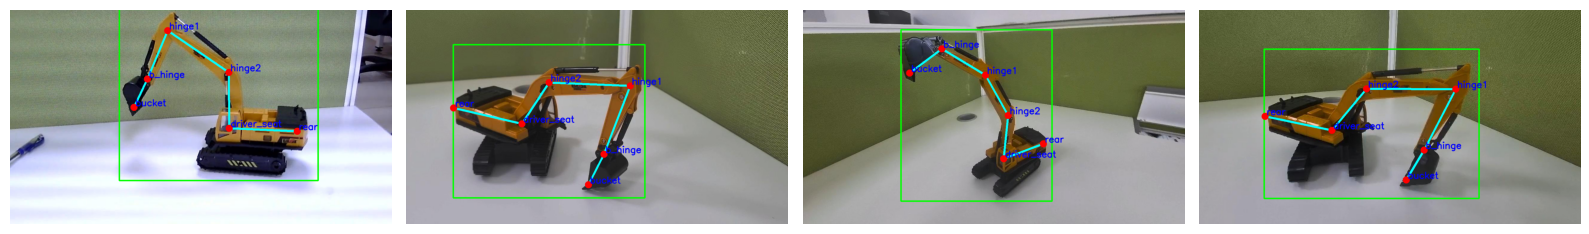

In [41]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog

# --- Config ---
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/valid"
model_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth"
score_thr = 0.5
num_samples = 4
keypoint_names = ["bucket", "hinge1", "hinge2", "driver_seat", "rear", "b_hinge"]
#skeleton = [('bucket', 'b_hinge'), ('hinge1', 'hinge2'), ('hinge2', 'driver_seat'), ('driver_seat', 'rear'), ('b_hinge', 'hinge1')]
skeleton = [[1, 6], [2, 3], [3, 4], [4, 5], [6, 2]]
class_names = ['Excavator']

# --- Detectron2 Config Setup ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_path

cfg.TEST.KEYPOINT_OKS_SIGMAS = [
    0.08,  # bucket – small and possibly occluded
    0.06,  # hinge1 – more flexible, more range
    0.05,  # hinge2 – large and rigid, some motion
    0.05,  # driver seat – stable location, rigid
    0.05,  # back of excavator – usually fixed and clearly visible
    0.06,  # bucket joint – joint, may move, moderate localization
]

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thr
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
cfg.TEST.DETECTIONS_PER_IMAGE = 1

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6

cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)

# --- Randomly Select Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

# --- Load and Predict ---
img_sizes = []
img_list = []
for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))
    img_sizes.append(img_rgb.shape[:2])

max_height = max(h for h, w in img_sizes)
max_width = max(w for h, w in img_sizes)

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    img_vis = img_rgb.copy()
    outputs = predictor(img_rgb)
    instances = outputs["instances"].to("cpu")

    # Filter by class and score
    boxes = instances.pred_boxes if instances.has("pred_boxes") else None
    scores = instances.scores if instances.has("scores") else None
    keypoints = instances.pred_keypoints if instances.has("pred_keypoints") else None

    for i in range(len(instances)):
        if scores[i] < score_thr:
            continue

        # Draw bounding box
        x1, y1, x2, y2 = map(int, boxes[i].tensor[0])
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Draw keypoints and skeleton
        kps = keypoints[i].numpy()  # shape: (7, 3)
        for pair in skeleton:
            i1, i2 = pair[0] - 1, pair[1] - 1
            if kps[i1][2] > 0.1 and kps[i2][2] > 0.1:
                pt1 = tuple(map(int, kps[i1][:2]))
                pt2 = tuple(map(int, kps[i2][:2]))
                cv2.line(img_vis, pt1, pt2, color=(0, 255, 255), thickness=6)

        for j, (x, y, v) in enumerate(kps):
            if v > 0.1:
                cv2.circle(img_vis, (int(x), int(y)), radius=12, color=(255, 0, 0), thickness=-1)
                cv2.putText(img_vis, keypoint_names[j], (int(x)+5, int(y)-5),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                            color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

    # Pad image for grid layout
    h, w = img_vis.shape[:2]
    top = (max_height - h) // 2
    bottom = max_height - h - top
    left = (max_width - w) // 2
    right = max_width - w - left
    img_padded = cv2.copyMakeBorder(img_vis, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_padded)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
import os
import random
import cv2
import time
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog

prev_boxes = []
prev_kps_list = []
# alpha closer to 1 = more stable, but more delay
alpha = 0.9  # Smoothing factor

# --- Configs and Paths ---
video_path = '/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/excavators-videos/excavatorvideo6.mp4'
save_path = '/content/gdrive/MyDrive/Pytorch-Models/excavators-videos-results/excavatorvideo6exp.mp4'

model_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth"

keypoint_names = ['bucket', 'hinge1', 'hinge2', 'driver_seat', 'rear', 'b_hinge']
skeleton = [(1, 6), (2, 3), (3, 4), (4, 5), (6, 2)]
keypoint_colors = [(0, 255, 255), (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255), (255, 0, 255)]
score_thr = 0.5
class_names = ['Excavator']

# --- Detectron2 Config Setup ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_path

cfg.TEST.KEYPOINT_OKS_SIGMAS = [
    0.08,  # bucket – small and possibly occluded
    0.06,  # hinge1 – more flexible, more range
    0.05,  # hinge2 – large and rigid, some motion
    0.05,  # driver seat – stable location, rigid
    0.05,  # back of excavator – usually fixed and clearly visible
    0.06,  # bucket joint – joint, may move, moderate localization
]

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thr
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
cfg.TEST.DETECTIONS_PER_IMAGE = 1

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6

cfg.MODEL.DEVICE = "cuda"

predictor = DefaultPredictor(cfg)

# --- Open Video ---
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
processed_frames = 0
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fixed_height = 720
aspect_ratio = w / h
new_width = int(fixed_height * aspect_ratio)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(save_path, fourcc, fps, (new_width, fixed_height))

pbar = tqdm(desc="Processing Video", total=total_frames)
prev_boxes = []
prev_kps_list = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (new_width, fixed_height))

    start_time = time.time()
    img_vis = frame.copy()

    outputs = predictor(img_vis)
    instances = outputs["instances"].to("cpu")

    # Filter by class and score
    boxes = instances.pred_boxes if instances.has("pred_boxes") else None
    scores = instances.scores if instances.has("scores") else None
    keypoints = instances.pred_keypoints if instances.has("pred_keypoints") else None

    for i in range(len(instances)):
        if scores[i] < score_thr:
            continue

        # Smooth bounding box
        if len(prev_boxes) == 0:
            smoothed_box = boxes[i].tensor[0].numpy()
        else:
            smoothed_box = alpha * prev_boxes[-1] + (1 - alpha) * boxes[i].tensor[0].numpy()

        prev_boxes.append(smoothed_box)
        x1, y1, x2, y2 = map(int, smoothed_box)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Draw keypoints and skeleton
        # Smooth keypoints
        kps = keypoints[i].numpy()
        if len(prev_kps_list) == 0:
            smoothed_kps = kps
        else:
            smoothed_kps = alpha * prev_kps_list[-1] + (1 - alpha) * kps

        prev_kps_list.append(smoothed_kps)

        for pair in skeleton:
            i1, i2 = pair[0] - 1, pair[1] - 1
            if smoothed_kps[i1][2] > 0.1 and smoothed_kps[i2][2] > 0.1:
                pt1 = tuple(map(int, smoothed_kps[i1][:2]))
                pt2 = tuple(map(int, smoothed_kps[i2][:2]))
                cv2.line(img_vis, pt1, pt2, color=(255, 255, 0), thickness=6)

        for j, (x, y, v) in enumerate(smoothed_kps):
            if v > 0.1:
                cv2.circle(img_vis, (int(x), int(y)), radius=12, color=keypoint_colors[j], thickness=-1)
                # cv2.putText(img_vis, keypoint_names[j], (int(x)+8, int(y)-8),
                #             fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                #             color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

        prev_boxes = prev_boxes[-1:]
        prev_kps_list = prev_kps_list[-1:]

    # --- FPS Counter ---
    fps_val = int(1.0 / (time.time() - start_time))
    fps_text = f'FPS: {fps_val}'
    cv2.putText(img_vis, fps_text, (10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                color=(255, 255, 255), thickness=2)

    writer.write(img_vis)
    processed_frames += 1
    pbar.update(1)

cap.release()
writer.release()
pbar.close()
print(f"\nOriginal total frames : {total_frames}")
print(f"Processed frames       : {processed_frames}")
print('Done: video saved at', save_path)

[07/25 21:36:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth ...


Processing Video: 100%|██████████| 2740/2740 [09:37<00:00,  4.74it/s]


Original total frames : 2740
Processed frames       : 2740
Done: video saved at /content/gdrive/MyDrive/Pytorch-Models/excavators-videos-results/excavatorvideo6exp.mp4


In [ ]:
[07/25 21:36:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth ...
Processing Video: 100%|██████████| 2740/2740 [09:37<00:00,  4.74it/s]
Original total frames : 2740
Processed frames       : 2740
Done: video saved at /content/gdrive/MyDrive/Pytorch-Models/excavators-videos-results/excavatorvideo6exp.mp4

In [ ]:
[07/25 21:20:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/Pytorch-Models/datasets/excavator/best_models/keypoint_best.pth ...
Processing Video: 100%|██████████| 501/501 [01:44<00:00,  4.77it/s]
Original total frames : 501
Processed frames       : 501
Done: video saved at /content/gdrive/MyDrive/Pytorch-Models/excavators-videos-results/excavatorvideo4exp.mp4

In [53]:
!ls -lh /content/gdrive/MyDrive/Pytorch-Models/excavators-videos-results/

total 132M
-rw------- 1 root root  23M Jul 25 21:22 excavatorvideo4exp.mp4
-rw------- 1 root root 110M Jul 25 21:45 excavatorvideo6exp.mp4
